In [125]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt
import ngfunction

In [126]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [127]:
zetas= np.array([0.7,0.9,1.4,1.8,2])
pars.set_matter_power(redshifts=zetas, kmax=1.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

Note: redshifts have been re-sorted (earliest first)


In [128]:
kh, z, pk = results.get_matter_power_spectrum(minkh=2e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza
z

[0.7, 0.9, 1.4, 1.8, 2.0]

In [129]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [130]:
z = np.array(z)

In [131]:
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(np.ones(len(z))+z)**3/(H(z)/H0)**2 #densità di materia a diverso z
omz

array([0.62105839, 0.69512272, 0.81937971, 0.87646453, 0.89630525])

Derivata composta della distanza cìdi luminosità

dr/dz =  c/H

dl = (1+z)*r 

dl'= r + (1+z)*c/H

In [132]:
bias = np.ones(len(z)) + z*0.84   #funzione di bias delle galassie, cercane altre!!

f = (results.get_fsigma8()/results.get_sigma8())
dl = results.luminosity_distance(z[0])
d = results.comoving_radial_distance(z[0])
 

fl= (2*d/(np.ones(len(z))+z))/(np.ones(len(z))*d+(np.ones(len(z))+z)*2.99e5/H(z))

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati


In [133]:
omz

array([0.62105839, 0.69512272, 0.81937971, 0.87646453, 0.89630525])

In [134]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu),len(zetas)))
for i in range (len(kh)):
    for j in range (len(mu)):
        for m in range (len(zetas)):
            Pgg[i][j][m] = float((bias[m] + fl[m] *f[m] * mu[j]**2)**2*pk[m,i])


In [135]:
err_Pgg = np.ones((len(kh),len(mu),len(zetas)))

In [136]:
gammas= np.arange(-2,4,0.05)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros((len(gammas),len(zetas)))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            for m in range (len(zetas)):
                chi2[k,m]= chi2[k,m]+(float((bias[m] + (omz[m]**gamma)*fl[m] * (mu[j])**2)**2*pk[m,i]) - Pgg[i][j][m])**2/err_Pgg[i][j][m]**2
        


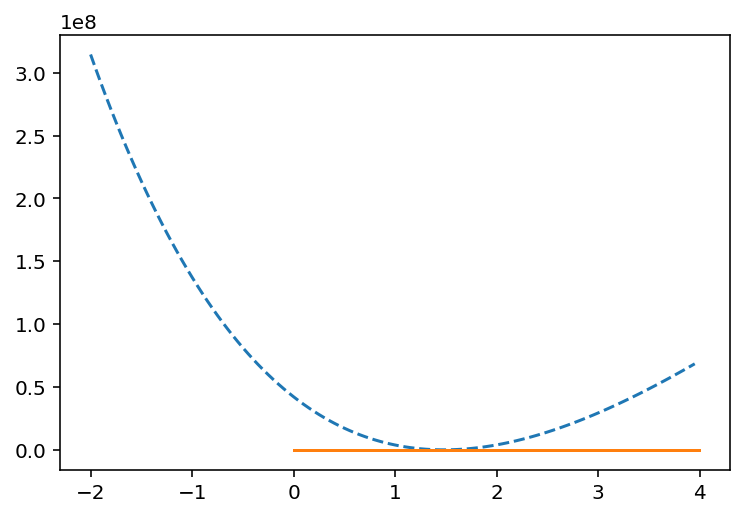

In [137]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol= np.empty(len(zetas), dtype=interpolate.interpolate.interp1d)
for i in range (len(zetas)):
    interpol[i] =  interpolate.interp1d(gammas,chi2[:,i],kind='cubic')

plt.plot(gammas, interpol[3](gammas), '--')
#plt.legend(['data', 'cubic'])
#plt.xlabel(' gamma ')
#plt.ylabel('Chi^2')

#CALCOLO DELL'ERRORE
xpoints= np.arange(0,4,0.005)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)




#plt.axis([0.54,0.56,0,3])


In [138]:
y = []

for i in range (len(zetas)):
    def y_(x):
        return interpol[i](x)
    y.append(y_)





In [139]:
minimo =[]
min=[]
chi2min = []

for i in range (len(zetas)):
    minimo.append(optimize.least_squares(y[i],0.5))
    min.append(float(minimo[i].x))
    chi2min.append(y[i](min[i]))



In [140]:
y1 = []
intersec1 = []
intersec2 = []

for i in range (len(zetas)):
    y1.append(lambda x: interpol[i](x) - 1 -chi2min[i])
    intersec1.append(optimize.brentq(y1[i],0.001,min[i]))
    intersec2.append(optimize.brentq(y1[i],min[i],3.9))    #trova le soluzioni in un intervallo fissato

print(intersec1,intersec2)



[0.11602800654290596, 0.18579564149644823, 0.5245868577377725, 1.478084400323065, 2.3481358088378492] [0.11649471169067085, 0.18612998762896235, 0.5248969613742401, 1.4786073728571847, 2.3488727885196887]


In [141]:
sigmad = np.zeros(len(zetas))
sigmas = np.zeros(len(zetas))

In [142]:
for i in range (len(zetas)):
    sigmad[i]=np.abs(min[i]-intersec1[i])

for i in range (len(zetas)):
    sigmas[i]=np.abs(min[i]-intersec2[i])




In [143]:
sigmas
#conclusione: gli errori sono sempre più piccoli

array([1.18988702e-06, 4.56770755e-06, 2.59459105e-04, 3.27746066e-04,
       3.75119261e-04])

In [144]:
sigmad


array([4.65515261e-04, 3.29778425e-04, 5.06445316e-05, 1.95226468e-04,
       3.61860421e-04])

In [145]:
func = lambda x: interpol[0](x) -chi2min[0]
func(min[0])

0.0

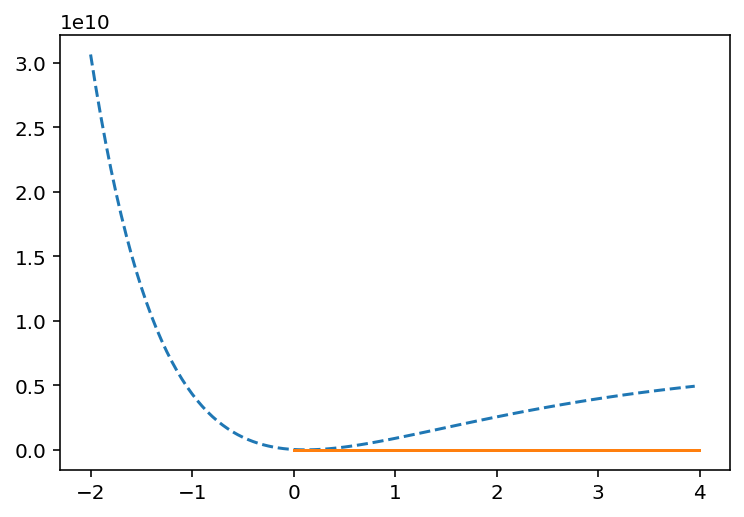

In [146]:
plt.plot(gammas,func(gammas), '--')
#plt.legend(['data', 'cubic'])
#plt.xlabel(' gamma ')
#plt.ylabel('Chi^2')

#CALCOLO DELL'ERRORE
xpoints= np.arange(0,4,0.005)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)

#plt.axis([0.05,0.175,-2e4,7e4])

Text(0, 0.5, ' sigma a sinistra')

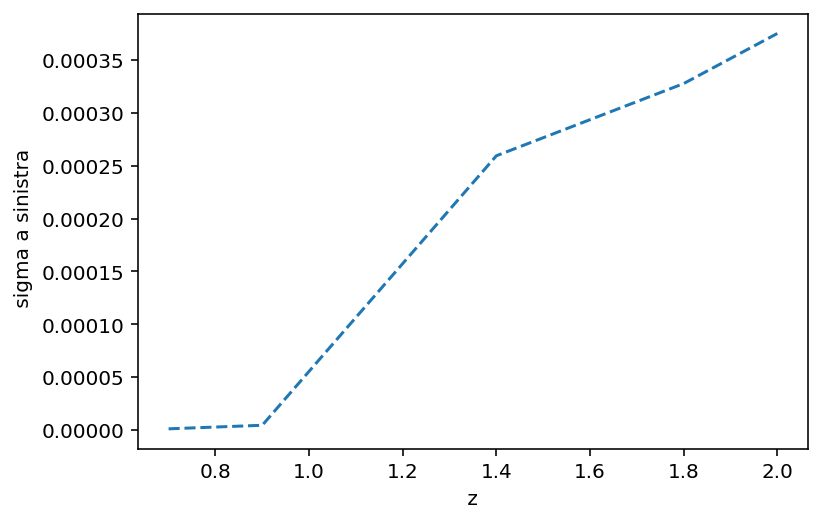

In [147]:
plt.plot(zetas, sigmas, '--')
plt.xlabel(' z ')
plt.ylabel(' sigma a sinistra')

Text(0, 0.5, ' sigma a destra')

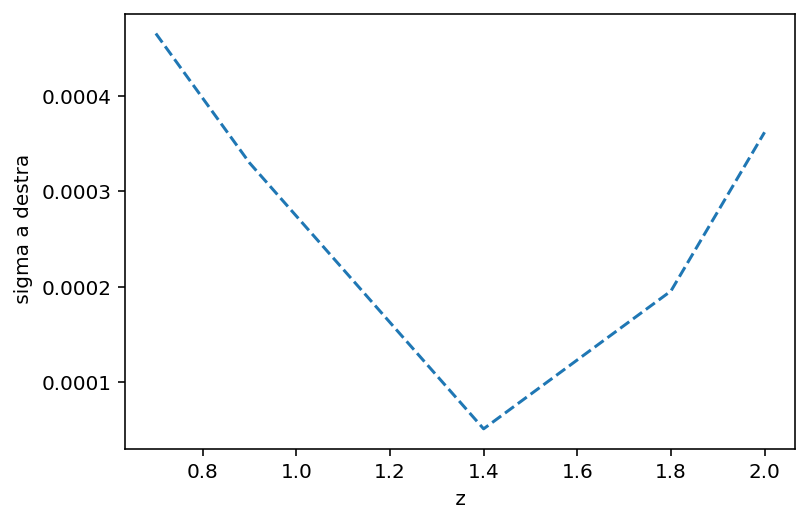

In [148]:
plt.plot(zetas, sigmad, '--')
plt.xlabel(' z ')
plt.ylabel(' sigma a destra')